In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_rows = 20
pd.options.display.max_columns = None

#pcapファイル読み込み
pcap = pd.read_csv('0000.csv',sep='|',quotechar='"')
print(len(pcap))

#ゴミデータ削除（数値変換できないものを捨てる）
pcap = pcap[~pd.to_numeric(pcap["ip.len"], errors="coerce").isnull()]

#型変換
pcap = pcap.astype({'ip.len': int,'ip.proto': int})

#統計情報出力
print(pcap['ip.proto'].value_counts(normalize=False))

#L4分離
pcap_tcp = pcap[pcap['ip.proto'] == 6]
pcap_udp = pcap[pcap['ip.proto'] == 17]

#ヘッダサイズ調整
pcap_tcp['ip.len'] = pcap_tcp['ip.len'] - 20 -20
pcap_udp['ip.len'] = pcap_udp['ip.len'] - 20 - 8

#L4結合
pcap = pd.concat([pcap_tcp,pcap_udp],axis=0)
pcap = pcap.sort_values('frame.time', ascending=True)

#リスト読み込み
iplist = pd.read_csv('iplist.csv')

#重複削除
iplist = iplist.drop_duplicates(subset='ip.src')


print(len(pcap_tcp))
print(len(pcap_udp))
print(len(pcap_tcp)+len(pcap_udp))

/opt/jupyter/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


331095
6     207989
17    123088
1         11
Name: ip.proto, dtype: int64


/opt/jupyter/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/jupyter/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


207989
123088
331077


In [2]:
#Join
resalt = pd.merge(pcap,iplist,how="left")

In [3]:
#時系列処理
#resalt['frame.time'] = pd.to_datetime(resalt['frame.time'])
#resalt.set_index('frame.time', inplace=True)
#resalt

In [4]:
resalt.groupby('domain').sum()

,ip.len,ip.proto
domain,,
aag.yahooapis.jp,1068104,7464
ad.jorudan.co.jp,112760,468
adingo.jp,172846,1032
ads.stickyadstv.com,6175,174
ads.yahoo.com,10651,270
...,...,...
static.doubleclick.net,47139,795
t.appsflyer.com,31318,420
tm.r-ad.ne.jp,590,66


In [5]:
resalt['domain'].value_counts().to_frame()

,domain
pagead-googlehosted.l.google.com,8780
doubleclick.net,4821
csi.gstatic.com,3759
adservice.google.co.jp,2350
aag.yahooapis.jp,1244
...,...
cdp.cloud.unity3d.com,4
d.image-ad.jp,3
cdn.treasuredata.com,3
pixon.ads-pixiv.net,3


In [6]:
resalt['domain'].value_counts(normalize=True).to_frame()

,domain
pagead-googlehosted.l.google.com,0.387587
doubleclick.net,0.212819
csi.gstatic.com,0.165938
adservice.google.co.jp,0.103739
aag.yahooapis.jp,0.054915
...,...
cdp.cloud.unity3d.com,0.000177
d.image-ad.jp,0.000132
cdn.treasuredata.com,0.000132
pixon.ads-pixiv.net,0.000132


In [7]:
resalt['domain'].value_counts(dropna=False,normalize=True).to_frame()

,domain
NaN,0.931578
pagead-googlehosted.l.google.com,0.026520
doubleclick.net,0.014562
csi.gstatic.com,0.011354
adservice.google.co.jp,0.007098
...,...
cdp.cloud.unity3d.com,0.000012
d.image-ad.jp,0.000009
pixon.ads-pixiv.net,0.000009
cdn.treasuredata.com,0.000009


In [8]:
resalt.groupby(['ip.dst','domain']).sum()

ip.len  ip.proto
ip.dst        domain                                  
100.103.0.10  doubleclick.net           6072       108
100.103.0.130 aag.yahooapis.jp            79        24
100.103.0.154 doubleclick.net           4343       255
100.103.0.16  doubleclick.net           7714       120
100.103.0.180 doubleclick.net            143        68
...                                      ...       ...
100.103.9.184 csi.gstatic.com             12         6
100.103.9.37  adservice.google.co.jp  139515      2378
              doubleclick.net              0        12
              static.doubleclick.net   11874       132
100.103.9.63  api.ads.newsdigest.jp      713        12

[464 rows x 2 columns]

In [9]:
#サンプリングユーザ数
resalt['ip.dst'].nunique()

1374

array([[<AxesSubplot:title={'center':'ip.len'}>,
        <AxesSubplot:title={'center':'ip.proto'}>]], dtype=object)

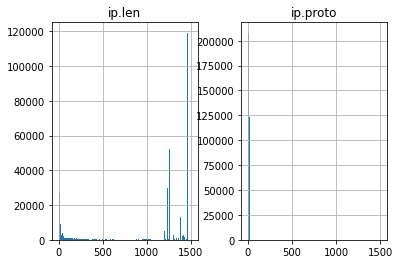

In [10]:
resalt.hist(bins=150,range=[0,1500])

array([[<AxesSubplot:title={'center':'ip.len'}>,
        <AxesSubplot:title={'center':'ip.proto'}>]], dtype=object)

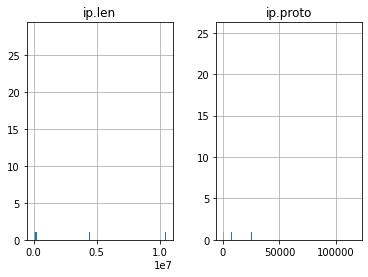

In [11]:
#resalt.plot()
resalt.groupby('domain').sum().hist(bins="auto")

<AxesSubplot:>

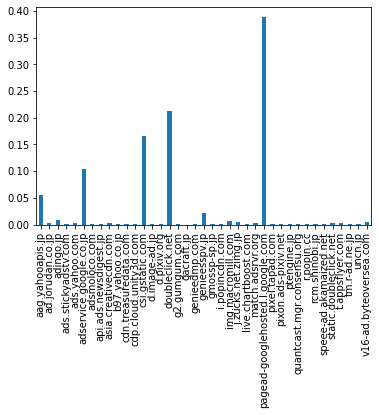

In [12]:
#resalt['domain'].value_counts(dropna=False,normalize=True).sort_index().reset_index()
resalt['domain'].value_counts(normalize=True).sort_index().plot(y='ip.len',kind='bar')

In [13]:
plt.plot(resalt['index'],resalt['ip.len'])

KeyError: 'index'

In [ ]:
resalt.to_csv('marge.csv', encoding='utf-8')

In [ ]:
#print(pcap.loc['2022-12-28 16:54:30'])
#pcap.date_range('2022-12-28', '2022-12-29', freq='M')
resalt.resample('S').sum()